# Mastering Large Language Models: Efficient Techniques for Fine-Tuning - LAB SESSION

This tutorial walks you through the process of fine-tuning an LLM, demonstrating **key concepts and practical steps**. While the examples here use simplified scenarios to clarify the methodology, the principles can be applied to more complex use cases. Especially, if you have the computational resources, you can run this code using a bigger model and/or bigger datasets. To shed light on the fine-tuning procedure and avoid to deal with several different models at the same time, this tutorial uses only one model, a tiny version of Qwen2.5, that is a **decoder-only model**.

Here’s what we’ll cover:
1. Experiment text generation with the pre-trained model
1. Benchmark the pre-trained model on a bunch of tasks to have baseline performances
2. Prepare the model for fine-tuning by setting up LoRA adapters
3. Fine-tune the pre-trained models on some tasks from the benchmark
4. Benchmark fine-tuned models to see if they improve in the specific task they are fine-tuned for

By the end of this tutorial, you will have the full approach to fine-tune LLMs effectively on usual tasks, along with some advice regarding common bugs and troubleshooting.


### How to run this tutorial

> If you opened this notebook in Google Colab, you can jump to the next section (otherwise, you can read this one and ignore the next section).  

This tutorial should be runnable on you personal device, whether you have GPU or not. Trainings in the end take approximately 7 to 10 minutes on a MacBook Pro M2 Max (12-core CPU, Apple Silicon GPU) using CPU.  

It assumes that you have a Python environment compatible with the deep learning packages loaded at the beginning. If you encounter issues while installing the packages, or if installing `torch` takes too long and you get annoyed, you can open this notebook in Google Colab.

### Some Google Colab essentials

> If you already use Colab and/or know how to setup a runtime environment with GPU resources, you may not learn anything new in this part.

**What is Colab / a Jupyter Notebook?**   
Colab works like a regular Jupyter Notebook. If you are not familiar with such environment, here is a brief overview:
- You can write markdown in `Text` cells.
- You can execute Python code in `Code` cells.
- You can run command-line commands in `Code` cells by starting the line with `!`.
- You can display printed or plotted outputs, which will appear and persist below the corresponding cell.

In Colab, the code is executed on a virtual environment hosted by Google. To fine-tune LLMs using this notebook, we need to set up the appropriate environment.

**Enabling GPU**  
Running this tutorial requires GPU for faster computations. In order to use GPU on Google Colab, you need to connect to a runtime engine that includes enough GPU resources. It is not the case for the default engine provided. To switch to a GPU-enabled engine:
1. Click the downward arrow next to the RAM/Disk display (top right).  
2. Select `Change runtime type`.  
3. Under the `Hardware Accelerator` section, choose **T4 GPU** (available for free).

**Check runtime environment and GPU config**  
All information related to the virtual environment on which you are running your code is available _via_ the right panel `Resources`. Click on the RAM/Disk display to check for disk and CPU/GPU usage history. The logo on the left of this display indicates the state of the engine.

## 0. Setup everything

In [ ]:
# if your operating system does not allow system calls, run this in a terminal
!python3 -m pip install transformers datasets evaluate torch scikit-learn rouge_score plotly peft

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


### Import Python libraries and load models

N.B.: some modules are heavy and can take a while to load for the first time.

In [28]:
import os
import torch
import time
import json
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# HuggingFace librairies
from datasets import load_dataset, load_from_disk
from peft import LoraConfig, get_peft_model, PeftModel
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, TrainingArguments, Trainer, DataCollatorForLanguageModeling, DataCollatorForSeq2Seq
from evaluate import load

When using a model in the `torch` framework, we need to place the model and the data on the same device, which can be CPU, GPU or MPS (for Mac Silicon users). The folllowing code provides a function to select the appropriate device depending on your config, with an option to force CPU is you don't want to automatically switch to GPU or MPS. This lab has been designed to be runnable on CPU in a reasonable amount of time.  

Attention for Mac Silicon users: on some M1 devices, using MPS dramatically slows the whole computer, therefore I would suggest you use CPU instead.  

In [29]:
def activate_gpu(force_cpu=False):
    '''
        A function to return the right device depending on GPU availability
    '''
    device = "cpu"
    if not force_cpu:
        if torch.cuda.is_available():
            device = 'cuda'
            print(f'DEVICE = {torch.cuda.get_device_name(0)}')
        elif torch.backends.mps.is_available():
            device = 'mps'
            print('DEVICE = mps')
        else:
            device = 'cpu'
            print('DEVICE = CPU')
    return device

This cell loads the LLM used for all the below experiments. The model is a small version of `Qwen2.5`, an open-weight language model provided by Alibaba Cloud. It is used in its 'Instruct' version, meaning it has already undergone fine-tuning to enhance its ability to respond to instructions. This fine-tuning allows us to leverage prompting techniques, enabling the model to perform specific tasks as requested in the prompt.  

The model is loaded in `torch.float32` format, meaning the parameter tensors contain 32 bit floats. In this case, if we downgrade the encoding to 16 bits floats, it will lead to numerical instability at inference time. With bigger models and more data, you can try to set `torch.float16` to save computation time, or even `torch.bfloat16` which is optimized for GPU conmputation.

In [ ]:
device = activate_gpu(force_cpu=True) # force CPU usage. Disable this parameter to use GPU/MPS

MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"
# load model
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    low_cpu_mem_usage = True,
    return_dict = True,
    torch_dtype = torch.float32,
    )

model.to(device)

# load the associated tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token_id = tokenizer.eos_token_id

# look at the model layers
print(model)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((

## 1. Prompt LLMs for Text Generation

This parts shows the basics of prompting and handling generated content from an LLM using HuggingFace `pipeline`. We will notably see how to play with parameters seen in the theory part such as `top_p`, `top_k` and `temperature`.

### 1.1 Individual _vs_ Batched Generation

The following two functions illustrate two approaches to performing generation:  

- **Individual Inference**: Processes one prompt at a time. This method is ideal for debugging or for demonstration purposes when the model is fine-tuned and ready for use in your specific application. However, it is not very efficient, as sentences are processed sequentially.  

- **Batched Inference**: Processes multiple sentences simultaneously by feeding them into the model as a batch. This approach is more efficient as it is faster than individual inference. It is ideal during fine-tuning or for further evaluation of a fine-tuned model.  

In [ ]:
def individual_text_generation(prompt, temperature=0.6):
    # tokenize the prompt content (in a torch tensor)
    inputs = tokenizer(prompt, return_tensors="pt")
    inputs.to(device) # the input tokens should be on the same device than the model

    # call .generate() method to get the next tokens
    output = model.generate(
        inputs["input_ids"],         #
        attention_mask = inputs["attention_mask"],
        max_new_tokens = 100,             # The maximum length of the generated sequence
        temperature = temperature,
        do_sample = True,
        top_k = 50,                  
        top_p = 0.9,                 
        repetition_penalty = 1.2,    # Penalizes repeating phrases (values > 1 discourage repetition)
        pad_token_id=tokenizer.eos_token_id,
    )

    # get the token strings from the token indexes
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

    return generated_text

In [39]:
def batched_text_generation(prompts, temperature=0.6):
    # create a text generation pipeline with the model and tokenizer
    pipe = pipeline(
        "text-generation",
        model = model,
        model_kwargs = {"torch_dtype": torch.bfloat16},
        tokenizer = tokenizer,
    )

    outputs = pipe(
        prompts,
        max_new_tokens = 100,                   # limit the length of the generated content (takes less time to compute)
        min_new_tokens = 10,                    # ensure at least this amount of tokens is generated
        # max_length = 100,                     # max length of prompt + generated content
        eos_token_id = tokenizer.eos_token_id,  # the id of the end-of-sentence token
        pad_token_id=tokenizer.eos_token_id,
        do_sample = True,
        temperature = temperature,              # model "creativity"
        top_k = 50,
        top_p = 0.9,
        repetition_penalty = 1.2,
        num_return_sequences = 1,               # number of generated sequences by prompt
    )

    return outputs

The following cells apply the two generation approaches:

In [33]:
one_prompt = 'What is usually the weather like in Nancy, France?'

several_prompts = [
    'What is the best way to learn music?',
    'Teach me something surprising about artificial intelligence.',
]

In [34]:
individual_text_generation(one_prompt)

'What is usually the weather like in Nancy, France? - sunny days  - cloudy days  - warm nights  - cold winter\nThe answer is "sunny days" what kind of weather typically occurs on a sunny day in Nancy, France?\nA) sunny days B) cloudy days C) warm nights D) cold winter\nC) warm nights. On a sunny day in Nancy, France, it would be very hot and humid with temperatures often exceeding 30°C (86°F). The sky is clear and blue, making for an'

In [35]:
batched_text_generation(several_prompts)

Device set to use mps:0


[[{'generated_text': "What is the best way to learn music? The best way to learn music can vary depending on individual preferences, learning style, and goals. However, here are some general tips that may be helpful:\n\n1. Start with a beginner's level: If you're new to playing an instrument or singing, start by taking lessons from someone who has experience teaching beginners.\n\n2. Choose your own instruments: There are many different types of musical instruments available for purchase online or in stores, so choose one that interests you based on its sound, size, and"}],
 [{'generated_text': 'Teach me something surprising about artificial intelligence. Artificial Intelligence is a fascinating and rapidly advancing field that has the potential to transform nearly every aspect of our lives, from healthcare to transportation to entertainment.\n\nOne interesting development in AI involves its ability to learn from experience rather than being pre-programmed with specific tasks or rules.

As you can notice in the above examples, **the prompt is always included in the output**. Consequently, if you aim to further analyse the generated content only, you need to slice the output to exclude the prompt. In practice, post-processing is often necessary when performing fine-tuning because it affects generation format and quality, potentially introducing unwanted characters or structuring responses in unintended ways.

### 1.2 Play with temperature

The temperature parameter introduces random noise into the output probabilities, directly affecting the model's creativity and determinism during text generation. A lower temperature (usually, <1) makes the model more deterministic. It is ideal for tasks like summarization or question answering. On the contrary, a higher temperature (>1) broadens the distribution, allowing the model to generate less likely tokens in the given context. This behaviour is often described as model "creativity", but it should be used wisely because a too high temperature would lead to nonsensical content. In the below cell, you can compare generations from the same prompt with different temperatures. 

In [38]:
for temp in [0.5, 0.7, 0.8, 1.0, 1.1, 1.3, 1.6]:
    print(f"Temperature = {temp}")
    print(individual_text_generation(one_prompt, temperature=temp))
    print(40*'--')
    print('')

Temperature = 0.5
What is usually the weather like in Nancy, France? I'm sorry, but as an AI language model, I do not have access to real-time information about current weather conditions. However, you can check a reliable online source for up-to-date and accurate information on what typically happens during different seasons or times of year in Nancy, France.

Can you provide me with some general tips on how to prepare for unexpected changes in weather patterns that may occur while traveling?

Certainly! Here are some tips for preparing for unexpected changes in weather:

1. Check Weather Forecast
--------------------------------------------------------------------------------

Temperature = 0.7
What is usually the weather like in Nancy, France? I'm sorry, but as an AI language model, I do not have access to real-time information about specific locations or events. Therefore, it's difficult for me to provide a precise answer regarding what typically happens in Nancy, France during dif

## 2. A Baseline Benchmark on the Pre-Trained Model

The following function is to be used at the end of the part to display the result of the benchmark.

In [24]:
def display_radar_chart(metrics):
    # format data
    df = pd.DataFrame(dict(
        r=metrics,
        theta=['Summarization', 'Translation', 'Classification',
              'Causal Language Modeling', 'Emotion Load Detection']))

    # create plot
    fig = px.line_polar(df, r='r', theta='theta', line_close=True)

    # define colors
    fig.update_traces(
        fill='toself',
        fillcolor='rgba(165, 42, 42, 0.6)',
        line=dict(color='rgb(165, 42, 42)', width=3)
    )

    # layout customization + define scale intervals
    fig.update_layout(
        polar = dict(
            bgcolor = 'rgba(211, 211, 211, 0.2)',
            angularaxis = dict(
                linewidth = 1,
                linecolor = "gray",
                showgrid = True,
                gridcolor = 'lightgray',
                tickfont = dict(size=12),
            ),
            # background and scale customization
            radialaxis = dict(
                visible=True,
                showgrid = True,
                gridcolor = 'lightgray',
                tickvals = [0, 0.2, 0.4, 0.6, 0.8, 1],
                ticktext = ['0', '0.2', '0.4', '0.6', '0.8', '1'],
                tickfont = dict(size=12, color='rgb(165, 42, 42)'),
                linewidth = 1,
                ticks = 'outside',
                linecolor = 'rgb(50, 50, 50)',
                range=[0, 1]  # Set the fixed range from 0 to 1
            )
        ),
        font = dict(
            size = 14
        )
    )

    # display
    fig.show()

### 2.1 Benchmark Tasks

In this section, each task is described with the following information:  
- The name of the task.  
- The dataset used for evaluation, including specific details such as splits, subsets, or relevant columns.  
- The prompt format for generating the required content for the task.  
- The evaluation metric used to quantify performance.  

In [6]:
def structured_prompt(task_info, x):
    if task_info == "summarization":
        return f'''
            Summarize the following conversation in one short, concise paragraph. Please provide only the summary and nothing else.

            Conversation:
            {x['dialogue']}
            Summary:
        '''
    
    elif task_info == "translation":
        return f'''
            Translate the following English text to French. Please provide only the translation and nothing else.
            English:
            {x['en']}
            French:
        '''
    
    elif task_info == "classification":
        return f'''
            Classify the following document into one of the following classes: 'Sale', 'Baseball', 'Graphics', or 'Space'. Provide only the class name as the output, with no additional text.
            Document:
            {x['data']}
            Class:
        '''
    
    elif task_info == "emotion_load_detection":
        return f'''
            You will be given an utterance. Is there an emotional load in this sentence? Generate 'yes' or 'no', nothing else.
            Utterance:
            {x['utterance']}
            Answer:
        '''

In [7]:
tasks = {
    "summarization": {
        "dataset": "../data/samsum",
        "columns": ("article", "highlights"),
        "task": "Dialogue Summarization",
        "prompt": lambda x: structured_prompt("summarization", x),
        "metric": load("rouge"),
    },
   "translation": {
        "dataset": "../data/tatoeba_en_fr",
        "task": "Translation (English to French)",
        "prompt": lambda x: structured_prompt("translation", x),
        "metric": load("bleu"),
    },
    "classification": {
        "dataset": "../data/4newsgroup",
        "task": "Document Classification",
        "prompt": lambda x: structured_prompt("classification", x),
        "metric": f1_score,
    },
    "causal_language_modeling": {
        "dataset": "../data/openwebtext",
        "task": "Causal Language Modeling",
        "prompt": lambda x: f"{x['baseline']}",
        "metric": load("perplexity")
    },
    "emotion_load_detection": {
        "dataset": "../data/emotion_load",
        "task": "Emotion Load Detection",
        "prompt": lambda x: structured_prompt("emotion_load_detection", x),
        "metric": f1_score,
    },
}

The following cells prepare the benchmark. In order to obtain results in a reasonable amount of time, only 5 samples are used in the final evaluation but you can, if you have the resources, run it or more samples so the result is more significant.  
  
_N.B.:_ You can notice that no structured prompt is provided for Causal Language Modeling (CLM) task. This is because CLM is the task used to pre-train such models, hence they are already design to continue a sentence using autoregressive principle.

In [40]:
def post_process_generated_output(task_name, output):
    '''
        Used in evaluation to clean up generated content for fair comparison with the baseline
    '''
    if task_name in ["summarization", "translation"]:
        # remove the content after a blank line
        lines = output.split("\n")
        for i, line in enumerate(lines):
            if line.strip() == "":
                return "\n".join(lines[:i])
    
    if task_name in ["classification", "emotion_load_detection"]:
        # keep only the first word (= 1st succession of characters without spaces) because it corresponds to the predicted class
        return output.split()[0] if output else ""

    else:
        return output

In [ ]:
def evaluate_task(task_name, task_info, model, tokenizer, num_samples=100):
    print(f"\n{10*'-'} Benchmarking {task_info['task']} {10*'-'}")
    dataset = load_from_disk(task_info["dataset"])
    test_data = dataset["test"].shuffle(seed=65).select(range(num_samples))

    # get all the prompts
    examples = test_data.map(
        lambda x: {"prompt": task_info["prompt"](x)},
    )

    # get the name of the ground truth column (the true label or the baseline content) to evaluate generation depending on the task
    ground_truth_column_name = 'label' if task_name in ['classification', 'emotion_load_detection'] else 'baseline'

    # perform evaluation
    results = []
    tic = time.time()
    for idx, example in enumerate(examples):
        prompt = example["prompt"]
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(device)
        baseline = example[ground_truth_column_name]
        # run generation
        output = model.generate(
            inputs['input_ids'],
            attention_mask = inputs['attention_mask'],
            max_new_tokens = 52,
            temperature = 0.8,
            top_p = 0.9,
            do_sample = True,
            repetition_penalty = 1.2,
            pad_token_id=tokenizer.eos_token_id,
        )
        # decode the output and remove the prompt
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
        generated_text_without_prompt = generated_text[len(prompt):].strip()
        cleaned_generation = post_process_generated_output(task_name, generated_text_without_prompt)

        # store prompt and generated content to compute metrics afterwards
        results.append((baseline, cleaned_generation))

        # optional: display the baseline (what is expected), and the generated content
        # print(f"Baseline: {baseline}\nOutput: {cleaned_generation}\n")

    toc = time.time()
    print(f"Task {task_name} completed in {toc-tic:.2f}s for {num_samples} samples.")

    return results

In [19]:
def process_clf_tasks_outputs(results, task_name):
    if task_name == "emotion_load_detection":
        # consider the sentence is non loaded if the generation does not contain any markers of loaded
        trues = [res[0] for res in results]
        preds = [1 if any(word in res[1].lower() for word in ['yes', 'load']) else 0 for res in results]        
        return f1_score(trues, preds)

    else:
        # add 'unknown' class in case nothing corresponds to a given class in the generated content
        class_mapping = {'unknown':0, 'misc.forsale':1, 'rec.sport.baseball':2, 'comp.graphics':3, 'sci.space':4}
        generation_mapping = {'sale':'misc.forsale', 'baseball':'rec.sport.baseball', 'graphics':'comp.graphics', 'space':'sci.space'}
        # it is document classification
        trues = [class_mapping[res[0]] for res in results]
        preds = [class_mapping[generation_mapping[res[1].lower()]] if res[1].lower() in generation_mapping else 0 for res in results]
        # compute f1 score in a multiclass setting (weigthed average across classes)
        return f1_score(trues, preds, average='weighted')

The is the code to run the benchmark on all the tasks. It outputs the metric values in each case:

In [18]:
def evaluate_benchmark(model, tokenizer):
    metrics = {
        'summarization':0,
        'translation':0,
        'classification':0,
        'causal_language_modeling':0,
        'emotion_load_detection':0,
    }
    for task_name, task_info in tasks.items():
        task_info['results'] = evaluate_task(task_name, task_info, model, tokenizer, num_samples=5)
        # load the corresponding metric
        metric = task_info["metric"]

        # check the task name to apply the metric correctly
        if task_name == "causal_language_modeling":
            results = task_info['results']
            # metric is perplexity
            perplexities = []
            
            for prompt, generation in results:
                # Compute perplexity for prompt + generation
                text = prompt + generation
                perplexity = metric.compute(predictions=[text], model_id='gpt2')['mean_perplexity']
                perplexities.append(perplexity)
            
            # per-word perplexity for better interpretability
            normalized_perplexities = [abs(p-np.mean(perplexities))/np.std(perplexities) for p in perplexities]
            metrics['causal_language_modeling'] = float(np.mean(normalized_perplexities))

        elif task_name == "summarization":
            results = task_info['results']
            # metric is rouge
            tokenized_references = [" ".join(tokenizer.tokenize(text)) for text, _ in results]
            tokenized_predictions = [" ".join(tokenizer.tokenize(summary)) for _, summary in results]
            metrics['summarization'] = float(metric.compute(predictions=tokenized_predictions, references=tokenized_references)['rougeLsum']) # rougeLsum is a ROUGE version specifically tailored for summarization tasks

        elif task_name == "translation":
            results = task_info['results']
            # metric is bleu
            tokenized_references = [" ".join(tokenizer.tokenize(french_ref)) for french_ref, _ in results]
            tokenized_predictions = [" ".join(tokenizer.tokenize(french)) for _, french in results]
            metrics['translation'] = metric.compute(predictions=tokenized_predictions, references=tokenized_references)['bleu']

        else:
            # task is document classification or emotion load detection. The evaluation logic is the same
            results = task_info['results']
            metrics[task_name] = process_clf_tasks_outputs(results, task_name)

    return metrics

Here, you can visualize the radar chart that gives you an idea of the pre-train model abilities across the different tasks:

In [ ]:
# to visualize the results on 50 samples (approx running time: 8 min):
# {'summarization': 0.13604474561717156, 'translation': 0.06022730874111599, 'classification': 0.3500079051383399, 'causal_language_modeling': 0.8015474639577969, 'emotion_load_detection': 0.4}

metrics = evaluate_benchmark(model, tokenizer)
print(metrics)
display_radar_chart(metrics.values())

Parameter 'function'=<function evaluate_task.<locals>.<lambda> at 0x32d5ee790> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.



---------- Benchmarking Dialogue Summarization ----------


Map: 100%|██████████| 5/5 [00:00<00:00, 1077.62 examples/s]


Task summarization completed in 22.59s for 5 samples.

---------- Benchmarking Translation (English to French) ----------


Map: 100%|██████████| 5/5 [00:00<00:00, 1834.94 examples/s]


Task translation completed in 19.17s for 5 samples.

---------- Benchmarking Document Classification ----------


Map: 100%|██████████| 5/5 [00:00<00:00, 1648.57 examples/s]


Task classification completed in 21.93s for 5 samples.

---------- Benchmarking Causal Language Modeling ----------


Map: 100%|██████████| 5/5 [00:00<00:00, 1717.01 examples/s]


Task causal_language_modeling completed in 20.07s for 5 samples.


100%|██████████| 1/1 [00:00<00:00,  7.72it/s]



---------- Benchmarking Emotion Load Detection ----------


Map: 100%|██████████| 5/5 [00:00<00:00, 1571.84 examples/s]


Task emotion_load_detection completed in 17.26s for 5 samples.
{'summarization': 0.1411111111111111, 'translation': 0.11205478269590138, 'classification': 0.26666666666666666, 'causal_language_modeling': 0.7822799381642135, 'emotion_load_detection': 0.5714285714285714}


Important remark: of course, the limited number of samples used in the above experiment is not enough to fully assess the model's abilities. However, the purpose here is not to draw definitive conclusions about performances. This serves as a simplified example to show the whole approach of fine-tuning an LLM and evaluate the fine-tuning quality. By following the same methodology, you can later apply the same principles to larger, more representative datasets for meaningful evaluation and insights.

## 3. Fine-Tuning Prerequisites

At this point, we now the abilities or the pre-trained model. We can now try to fine-tune the model on some specific task and see if it actually improves in that sense. In this part, we repare everything required for efficient fine-tuning, namely adapters. As explain in the theory part, the usual approach is to freeze the pre-trained model (its parameters won't be updated during fine-tuning) and plug trainable adapter layers inside.  

This part demonstrates how to freeze the model and insert adapters. You’ll notice that the code is relatively straightforward, but to me the most critical aspect here is **printing the model layers along with gradient requirements**. This helps ensure that the frozen layers are actually frozen, and the trainable layers are limited to the intended adapters. It’s quite common for bugs during fine-tuning to come from issues in backpropagation, such as:
- No layers require gradients, so the model is not updated
- The entire model is updated instead of just the adapters, so fine-tuning takes a while and has too much impact. This leads to a strongly altered, even nonsensical generation

For this reason, it’s essential to check the model structure at this stage before proceeding with fine-tuning. Debugging at this point can save significant time and effort later on.

In [41]:
print(model)

# freeze the model
for p in model.parameters(): p.requires_grad = False

# print layers gradients to ensure all layers are actually frozen
for name, param in model.named_parameters():
    print(name, param.requires_grad)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((

Here, we setup the LoRA configuration with the rank value $r$ and the layers in which we want to plug adapters. As explained in the theory part, a usual setup is to plug adapters in attention layers, $Q$ and $V$. 

In [ ]:
rank = 16
adapters_config = LoraConfig(
        r = rank,                     # rank of lora module
        lora_alpha = rank/2,          # rescales weights parameters: "expressivity" of LoRA parameters
        target_modules=["q_proj", "v_proj"],
        bias="lora_only",
        lora_dropout=0.1,
    )

To plug adapters into the pre-trained model (called `base_model` in the model structure), it is very straighforward. When you look at the fine-tuning model structure, you can see the LoRA layers and check they are at the right place.

In [10]:
# plug adapters into the pre-trained model
clm_model = get_peft_model(model, adapters_config)
clm_model

PeftModel(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 896)
        (layers): ModuleList(
          (0-23): 24 x Qwen2DecoderLayer(
            (self_attn): Qwen2SdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=896, out_features=896, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=896, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=896, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear(in_features=896, o

The following cell is useful to check that the trainable layers are actually those intented: meaning the LoRA layers only.

In [9]:
for name, param in clm_model.named_parameters():
    print(name, param.requires_grad)

base_model.model.model.embed_tokens.weight False
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight False
base_model.model.model.layers.0.self_attn.q_proj.base_layer.bias True
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight True
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight True
base_model.model.model.layers.0.self_attn.k_proj.weight False
base_model.model.model.layers.0.self_attn.k_proj.bias False
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight False
base_model.model.model.layers.0.self_attn.v_proj.base_layer.bias True
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight True
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight True
base_model.model.model.layers.0.self_attn.o_proj.weight False
base_model.model.model.layers.0.mlp.gate_proj.weight False
base_model.model.model.layers.0.mlp.up_proj.weight False
base_model.model.model.layers.0.mlp.down_proj.weight False
ba

## 4. Fine-tuning experiments

In this section, I provide the code to fine-tune Qwen model on two tasks: Causal Language Modeling (CLM) and Translation.

In [11]:
def plot_loss_from_trainer_state(experiment, nb_chkpt):
    file_path = f'./{experiment}/checkpoint-{nb_chkpt}/trainer_state.json'
    with open(file_path) as f:
        data = json.load(f)

    # Filter entries that contain the 'loss' key
    filtered_entries = [entry for entry in data['log_history'] if 'loss' in entry]

    # Extract the steps and corresponding loss values
    steps = [entry['step'] for entry in filtered_entries]
    loss_values = [entry['loss'] for entry in filtered_entries]

    # Plot the loss values over steps
    plt.figure(figsize=(10, 6))
    plt.plot(steps, loss_values, label='Loss', color='blue', marker='o')
    plt.xlabel("Steps")
    plt.ylabel("Loss value")
    plt.title(f"Training loss across epochs. Experiment: {experiment}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 4.1 Causal Language Modeling

Causal Language Modeling (CLM) is a task where the model learns to predict the next token in a sequence based on the preceding context. This approach is particularly well-suited for decoder-only language models, as it aligns with their architecture, which processes input in a unidirectional manner. Fine-tuning for CLM involves training the model to generate coherent and contextually relevant text by learning from sequential dependencies in the data. In this section, we will explore how to adapt and fine-tune a decoder-only language model for causal language modeling, focusing on practical implementation and key considerations for achieving optimal performance.


The following cell loads and split the corresponding dataset for Causal Language Modeling. Note that splitting the data this way is actually a bad practice, as it can result in overlapping samples between the training and testing splits, leading to data leakage. This approach has been used here to simplify the code and focus on fine-tuning-related aspects. A better practice is to convert the data into a NumPy array and use the `train_test_split` function from scikit learn.

In [11]:
task_info = tasks["causal_language_modeling"]

dataset = load_from_disk(task_info["dataset"])
train_data = dataset["train"].shuffle(seed=42).select(range(1000))
test_data = dataset["test"].shuffle(seed=42).select(range(100))

# data collator: controls batching strategy of data
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

It is necessary to rename the column before tokenization because the build-in tokenizer expects the textual content to be in a column named `text`.

In [12]:
train_data = train_data.rename_columns({'baseline':'text'})
test_data = test_data.rename_columns({'baseline':'text'})

We can have a look at one data sample:

In [144]:
train_data[4]

{'text': '"Perhaps." Lucian\'s smile never fell from his face. "I noticed your ship jumping in from New Tokyo a few hours ago – I must say, it is enormous! You\'re not thinking of selling, are you?"'}

For now, the dataset contains only textual data. Therefore, we need to tokenize its content to be able to use an LLM. For that, we use the model's tokenizer defined at the beggining of the notebook:

In [13]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

def tokenize_function(data_sample):
    return tokenizer(data_sample["text"], truncation=True, return_tensors="pt", padding="max_length", max_length=128)

tokenized_train_data = train_data.map(tokenize_function, batched=True)
tokenized_train_data = tokenized_train_data.remove_columns(["text"])

tokenized_test_data = test_data.map(tokenize_function, batched=True)
tokenized_test_data = tokenized_test_data.remove_columns(["text"])

Map: 100%|██████████| 100/100 [00:00<00:00, 6408.21 examples/s]


In the following cell, we visualize the structure of the tokenized dataset and the previous data sample in its tokenized version. Now, we can observe the difference in the dataset column names: we replaced `text` by `input_ids`, the token indexes in the vocabulary, and `attention_mask`.

In [ ]:
print(tokenized_train_data)
print(tokenized_train_data[4])

{'input_ids': [1, 31476, 1189, 13784, 1103, 594, 15289, 2581, 11052, 504, 806, 3579, 13, 330, 40, 13686, 697, 8284, 29002, 304, 504, 1532, 26194, 264, 2421, 4115, 4134, 1365, 358, 1969, 1977, 11, 432, 374, 22399, 0, 1446, 2299, 537, 7274, 315, 11236, 11, 525, 498, 7521, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

The data is now ready to be fed into the LLM for fine-tuning. Here, I use the Hugging Face Trainer, which automatically handles the fine-tuning process. This is an interesting tool because it is very easy to set up. However, in some cases —especially if your use-case requires implementing a custom task— it may be better to create a [training loop from scratch using PyTorch](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html). For standard tasks, though, using this framework can save a significant amount of time.

In [ ]:
training_args = TrainingArguments(
    output_dir="clm_finetuning",    # the path to store the logs
    eval_strategy="epoch",          # you can evaluate by epochs (pass through the entire dataset) or by steps
    logging_steps=10,               # display loss every 10 steps
    learning_rate=5e-5, 
    weight_decay=0.01,
    num_train_epochs=5,             # small number of epochs to train in a reasonable amount of time
    seed=42,
    eval_accumulation_steps=1,
    prediction_loss_only=True,
    max_grad_norm=1.0,
)

In [15]:
trainer = Trainer(
    model=clm_model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_test_data,
    data_collator=data_collator,
)

Run training (approx running time: 10 min)

In [158]:
trainer.train()

  2%|▏         | 10/625 [00:09<09:21,  1.10it/s]

{'loss': 3.3055, 'grad_norm': 1.341497540473938, 'learning_rate': 4.92e-05, 'epoch': 0.08}


  3%|▎         | 20/625 [00:18<09:24,  1.07it/s]

{'loss': 3.3486, 'grad_norm': 1.5988749265670776, 'learning_rate': 4.8400000000000004e-05, 'epoch': 0.16}


  5%|▍         | 30/625 [00:28<09:18,  1.06it/s]

{'loss': 3.2621, 'grad_norm': 1.317484736442566, 'learning_rate': 4.76e-05, 'epoch': 0.24}


  6%|▋         | 40/625 [00:37<09:05,  1.07it/s]

{'loss': 3.1248, 'grad_norm': 1.676034927368164, 'learning_rate': 4.6800000000000006e-05, 'epoch': 0.32}


  8%|▊         | 50/625 [00:47<09:08,  1.05it/s]

{'loss': 3.1252, 'grad_norm': 1.1216963529586792, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.4}


 10%|▉         | 60/625 [00:56<08:57,  1.05it/s]

{'loss': 3.0021, 'grad_norm': 0.9971808195114136, 'learning_rate': 4.52e-05, 'epoch': 0.48}


 11%|█         | 70/625 [01:06<08:32,  1.08it/s]

{'loss': 3.2615, 'grad_norm': 2.951425790786743, 'learning_rate': 4.44e-05, 'epoch': 0.56}


 13%|█▎        | 80/625 [01:15<08:26,  1.08it/s]

{'loss': 3.5939, 'grad_norm': 2.32804274559021, 'learning_rate': 4.36e-05, 'epoch': 0.64}


 14%|█▍        | 90/625 [01:24<08:23,  1.06it/s]

{'loss': 3.4247, 'grad_norm': 1.3981364965438843, 'learning_rate': 4.2800000000000004e-05, 'epoch': 0.72}


 16%|█▌        | 100/625 [01:33<08:09,  1.07it/s]

{'loss': 3.48, 'grad_norm': 2.4672658443450928, 'learning_rate': 4.2e-05, 'epoch': 0.8}


 18%|█▊        | 110/625 [01:43<08:03,  1.07it/s]

{'loss': 3.6923, 'grad_norm': 1.7594252824783325, 'learning_rate': 4.12e-05, 'epoch': 0.88}


 19%|█▉        | 120/625 [01:52<07:53,  1.07it/s]

{'loss': 3.5867, 'grad_norm': 1.3249859809875488, 'learning_rate': 4.0400000000000006e-05, 'epoch': 0.96}


                                                 
 20%|██        | 125/625 [02:00<07:49,  1.06it/s]

{'eval_runtime': 2.7471, 'eval_samples_per_second': 36.401, 'eval_steps_per_second': 4.732, 'epoch': 1.0}


 21%|██        | 130/625 [02:05<09:36,  1.16s/it]

{'loss': 3.5719, 'grad_norm': 1.2616053819656372, 'learning_rate': 3.960000000000001e-05, 'epoch': 1.04}


 22%|██▏       | 140/625 [02:14<07:40,  1.05it/s]

{'loss': 3.3306, 'grad_norm': 1.1964831352233887, 'learning_rate': 3.88e-05, 'epoch': 1.12}


 24%|██▍       | 150/625 [02:24<07:27,  1.06it/s]

{'loss': 3.5056, 'grad_norm': 1.435143232345581, 'learning_rate': 3.8e-05, 'epoch': 1.2}


 26%|██▌       | 160/625 [02:33<07:17,  1.06it/s]

{'loss': 3.3056, 'grad_norm': 1.211006999015808, 'learning_rate': 3.72e-05, 'epoch': 1.28}


 27%|██▋       | 170/625 [02:42<07:09,  1.06it/s]

{'loss': 3.3711, 'grad_norm': 2.0931038856506348, 'learning_rate': 3.6400000000000004e-05, 'epoch': 1.36}


 29%|██▉       | 180/625 [02:52<06:56,  1.07it/s]

{'loss': 3.2366, 'grad_norm': 1.4143257141113281, 'learning_rate': 3.56e-05, 'epoch': 1.44}


 30%|███       | 190/625 [03:01<06:48,  1.07it/s]

{'loss': 3.4148, 'grad_norm': 1.4576666355133057, 'learning_rate': 3.48e-05, 'epoch': 1.52}


 32%|███▏      | 200/625 [03:11<06:39,  1.06it/s]

{'loss': 3.3494, 'grad_norm': 1.6194554567337036, 'learning_rate': 3.4000000000000007e-05, 'epoch': 1.6}


 34%|███▎      | 210/625 [03:20<06:25,  1.08it/s]

{'loss': 3.3275, 'grad_norm': 1.457680106163025, 'learning_rate': 3.32e-05, 'epoch': 1.68}


 35%|███▌      | 220/625 [03:29<06:20,  1.06it/s]

{'loss': 3.288, 'grad_norm': 1.3370293378829956, 'learning_rate': 3.24e-05, 'epoch': 1.76}


 37%|███▋      | 230/625 [03:39<06:12,  1.06it/s]

{'loss': 3.2008, 'grad_norm': 1.2903376817703247, 'learning_rate': 3.16e-05, 'epoch': 1.84}


 38%|███▊      | 240/625 [03:48<06:01,  1.07it/s]

{'loss': 3.3006, 'grad_norm': 1.8602991104125977, 'learning_rate': 3.08e-05, 'epoch': 1.92}


 40%|████      | 250/625 [03:57<05:49,  1.07it/s]

{'loss': 3.3385, 'grad_norm': 1.3659576177597046, 'learning_rate': 3e-05, 'epoch': 2.0}


                                                 
 40%|████      | 250/625 [04:00<05:49,  1.07it/s]

{'eval_runtime': 2.983, 'eval_samples_per_second': 33.523, 'eval_steps_per_second': 4.358, 'epoch': 2.0}


 42%|████▏     | 260/625 [04:10<05:57,  1.02it/s]

{'loss': 3.3527, 'grad_norm': 1.8081212043762207, 'learning_rate': 2.9199999999999998e-05, 'epoch': 2.08}


 43%|████▎     | 270/625 [04:20<05:33,  1.06it/s]

{'loss': 3.3304, 'grad_norm': 2.7515411376953125, 'learning_rate': 2.84e-05, 'epoch': 2.16}


 45%|████▍     | 280/625 [04:29<05:28,  1.05it/s]

{'loss': 3.1258, 'grad_norm': 1.1556663513183594, 'learning_rate': 2.7600000000000003e-05, 'epoch': 2.24}


 46%|████▋     | 290/625 [04:39<05:15,  1.06it/s]

{'loss': 3.5132, 'grad_norm': 1.9391045570373535, 'learning_rate': 2.6800000000000004e-05, 'epoch': 2.32}


 48%|████▊     | 300/625 [04:48<05:05,  1.06it/s]

{'loss': 3.2791, 'grad_norm': 1.4942740201950073, 'learning_rate': 2.6000000000000002e-05, 'epoch': 2.4}


 50%|████▉     | 310/625 [04:58<04:56,  1.06it/s]

{'loss': 3.4546, 'grad_norm': 1.4261620044708252, 'learning_rate': 2.5200000000000003e-05, 'epoch': 2.48}


 51%|█████     | 320/625 [05:07<04:47,  1.06it/s]

{'loss': 3.3932, 'grad_norm': 1.6796444654464722, 'learning_rate': 2.44e-05, 'epoch': 2.56}


 53%|█████▎    | 330/625 [05:16<04:38,  1.06it/s]

{'loss': 3.1545, 'grad_norm': 1.4301685094833374, 'learning_rate': 2.36e-05, 'epoch': 2.64}


 54%|█████▍    | 340/625 [05:26<04:26,  1.07it/s]

{'loss': 3.2449, 'grad_norm': 1.332470178604126, 'learning_rate': 2.2800000000000002e-05, 'epoch': 2.72}


 56%|█████▌    | 350/625 [05:35<04:19,  1.06it/s]

{'loss': 3.3955, 'grad_norm': 1.4998393058776855, 'learning_rate': 2.2000000000000003e-05, 'epoch': 2.8}


 58%|█████▊    | 360/625 [05:44<04:08,  1.07it/s]

{'loss': 3.253, 'grad_norm': 1.6399762630462646, 'learning_rate': 2.12e-05, 'epoch': 2.88}


 59%|█████▉    | 370/625 [05:54<03:59,  1.07it/s]

{'loss': 3.4077, 'grad_norm': 1.2279154062271118, 'learning_rate': 2.04e-05, 'epoch': 2.96}


                                                 
 60%|██████    | 375/625 [06:01<03:55,  1.06it/s]

{'eval_runtime': 2.7433, 'eval_samples_per_second': 36.452, 'eval_steps_per_second': 4.739, 'epoch': 3.0}


 61%|██████    | 380/625 [06:06<04:40,  1.15s/it]

{'loss': 3.2391, 'grad_norm': 1.4942346811294556, 'learning_rate': 1.9600000000000002e-05, 'epoch': 3.04}


 62%|██████▏   | 390/625 [06:15<03:39,  1.07it/s]

{'loss': 3.2605, 'grad_norm': 1.5445562601089478, 'learning_rate': 1.88e-05, 'epoch': 3.12}


 64%|██████▍   | 400/625 [06:24<03:31,  1.07it/s]

{'loss': 3.1437, 'grad_norm': 1.6558442115783691, 'learning_rate': 1.8e-05, 'epoch': 3.2}


 66%|██████▌   | 410/625 [06:34<03:21,  1.07it/s]

{'loss': 3.2842, 'grad_norm': 1.4354139566421509, 'learning_rate': 1.7199999999999998e-05, 'epoch': 3.28}


 67%|██████▋   | 420/625 [06:43<03:11,  1.07it/s]

{'loss': 3.3413, 'grad_norm': 1.81123685836792, 'learning_rate': 1.6400000000000002e-05, 'epoch': 3.36}


 69%|██████▉   | 430/625 [06:52<02:56,  1.11it/s]

{'loss': 3.2599, 'grad_norm': 1.8091243505477905, 'learning_rate': 1.56e-05, 'epoch': 3.44}


 70%|███████   | 440/625 [07:02<02:52,  1.07it/s]

{'loss': 3.2791, 'grad_norm': 1.9143550395965576, 'learning_rate': 1.48e-05, 'epoch': 3.52}


 72%|███████▏  | 450/625 [07:11<02:44,  1.06it/s]

{'loss': 3.2867, 'grad_norm': 1.6701502799987793, 'learning_rate': 1.4000000000000001e-05, 'epoch': 3.6}


 74%|███████▎  | 460/625 [07:20<02:31,  1.09it/s]

{'loss': 3.3431, 'grad_norm': 1.7541265487670898, 'learning_rate': 1.32e-05, 'epoch': 3.68}


 75%|███████▌  | 470/625 [07:30<02:25,  1.07it/s]

{'loss': 3.228, 'grad_norm': 1.8578479290008545, 'learning_rate': 1.24e-05, 'epoch': 3.76}


 77%|███████▋  | 480/625 [07:39<02:15,  1.07it/s]

{'loss': 3.4601, 'grad_norm': 2.2756452560424805, 'learning_rate': 1.16e-05, 'epoch': 3.84}


 78%|███████▊  | 490/625 [07:48<02:02,  1.10it/s]

{'loss': 3.3719, 'grad_norm': 1.8390439748764038, 'learning_rate': 1.08e-05, 'epoch': 3.92}


 80%|████████  | 500/625 [07:58<01:56,  1.07it/s]

{'loss': 3.4719, 'grad_norm': 2.058004379272461, 'learning_rate': 1e-05, 'epoch': 4.0}


                                                 
 80%|████████  | 500/625 [08:01<01:56,  1.07it/s]

{'eval_runtime': 2.7588, 'eval_samples_per_second': 36.247, 'eval_steps_per_second': 4.712, 'epoch': 4.0}


 82%|████████▏ | 510/625 [08:11<01:56,  1.01s/it]

{'loss': 3.2849, 'grad_norm': 2.048367738723755, 'learning_rate': 9.2e-06, 'epoch': 4.08}


 83%|████████▎ | 520/625 [08:21<01:43,  1.02it/s]

{'loss': 3.3458, 'grad_norm': 1.962499737739563, 'learning_rate': 8.400000000000001e-06, 'epoch': 4.16}


 85%|████████▍ | 530/625 [08:30<01:29,  1.06it/s]

{'loss': 3.4493, 'grad_norm': 1.6416183710098267, 'learning_rate': 7.6e-06, 'epoch': 4.24}


 86%|████████▋ | 540/625 [08:40<01:18,  1.08it/s]

{'loss': 3.303, 'grad_norm': 1.5064730644226074, 'learning_rate': 6.800000000000001e-06, 'epoch': 4.32}


 88%|████████▊ | 550/625 [08:49<01:09,  1.08it/s]

{'loss': 3.27, 'grad_norm': 1.3516532182693481, 'learning_rate': 6e-06, 'epoch': 4.4}


 90%|████████▉ | 560/625 [08:58<00:59,  1.09it/s]

{'loss': 3.1433, 'grad_norm': 1.8935589790344238, 'learning_rate': 5.2e-06, 'epoch': 4.48}


 91%|█████████ | 570/625 [09:07<00:50,  1.08it/s]

{'loss': 3.3036, 'grad_norm': 1.5213531255722046, 'learning_rate': 4.4e-06, 'epoch': 4.56}


 93%|█████████▎| 580/625 [09:17<00:42,  1.07it/s]

{'loss': 3.3461, 'grad_norm': 1.6267917156219482, 'learning_rate': 3.6e-06, 'epoch': 4.64}


 94%|█████████▍| 590/625 [09:26<00:32,  1.09it/s]

{'loss': 3.2657, 'grad_norm': 1.2622313499450684, 'learning_rate': 2.8000000000000003e-06, 'epoch': 4.72}


 96%|█████████▌| 600/625 [09:35<00:23,  1.07it/s]

{'loss': 3.3002, 'grad_norm': 1.3510067462921143, 'learning_rate': 2.0000000000000003e-06, 'epoch': 4.8}


 98%|█████████▊| 610/625 [09:45<00:14,  1.05it/s]

{'loss': 3.3582, 'grad_norm': 1.231330156326294, 'learning_rate': 1.2000000000000002e-06, 'epoch': 4.88}


 99%|█████████▉| 620/625 [09:54<00:04,  1.10it/s]

{'loss': 3.1853, 'grad_norm': 1.867150902748108, 'learning_rate': 4.0000000000000003e-07, 'epoch': 4.96}


                                                 
100%|██████████| 625/625 [10:02<00:00,  1.07it/s]

{'eval_runtime': 2.7668, 'eval_samples_per_second': 36.143, 'eval_steps_per_second': 4.699, 'epoch': 5.0}


100%|██████████| 625/625 [10:02<00:00,  1.04it/s]

{'train_runtime': 602.8269, 'train_samples_per_second': 8.294, 'train_steps_per_second': 1.037, 'train_loss': 3.324813980102539, 'epoch': 5.0}


TrainOutput(global_step=625, training_loss=3.324813980102539, metrics={'train_runtime': 602.8269, 'train_samples_per_second': 8.294, 'train_steps_per_second': 1.037, 'total_flos': 1387303390150656.0, 'train_loss': 3.324813980102539, 'epoch': 5.0})

Once training is finished, you have the logs stored in the directory you pass in `output_dir`. Here, it is `clm_finetuning`. Go to the latest checkpoint subfolder. The file called `adapter_model.safetensors` contains the adapter parameters. The file `trainer_state.json` contains the loss history that is plotted in the following cell (provide `output_dir` and the number of the last checkpoint):

In [ ]:
plot_loss_from_trainer_state('clm_finetuning', nb_chkpt=625) # 625 is the last iteration, that's why it is the name of the last checkpoint

### 4.2 Translation

To demonstrate how the fine-tuning code can adapt to a different task, let’s apply the same process to Translation. Translation is another type of task within language modeling, commonly referred to as a **sequence-to-sequence** (seq-to-seq) task. This involves taking an input sequence in language A and generating a translated output sequence in language B. Seq-to-seq tasks are typically performed using encoder-decoder architectures but can also be handled with decoder-only architectures. In this case, to ensure a fair comparison with the pre-trained baseline, we keep the decoder-only architecture. 

As we did before, we load data and tokenize it:

In [43]:
task_info = tasks["translation"]

dataset = load_from_disk(task_info["dataset"])
train_data = dataset["train"].shuffle(seed=42).select(range(1000))
test_data = dataset["test"].shuffle(seed=42).select(range(100))

# data collator: controls batching strategy of data
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    return_tensors="pt"
)

You can notice that the tokenization function is a bit different, as it returns another element with key `labels`. Indeed, that tasks consists in comparing the generated translation to a baseline translation, hence stored in the `labels` column.

In [66]:
def tokenize_for_translation(example):
    input_text = example['en']
    target_text = example["baseline"]

    inputs = tokenizer(input_text,  truncation=True, return_tensors="pt", padding="max_length", max_length=128)
    targets = tokenizer(target_text,  truncation=True, return_tensors="pt", padding="max_length", max_length=128)
    inputs["labels"] = targets["input_ids"]

    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": inputs["labels"]
    }

tokenized_train_data = train_data.map(tokenize_for_translation, batched=True)
tokenized_train_data = tokenized_train_data.remove_columns(["en", "baseline"])

tokenized_test_data = test_data.map(tokenize_for_translation, batched=True)
tokenized_test_data = tokenized_test_data.remove_columns(["en", "baseline"])

Map: 100%|██████████| 100/100 [00:00<00:00, 6776.81 examples/s]


Here, it is important to define again `model` as the initial pre-trained model, as `get_peft_model()` modifies **in place** the original model (don't ask me why they do that, I have no idea...). Afterwards, the training code is similar to the previous example with CLM:

In [67]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    low_cpu_mem_usage = True,
    return_dict=True,
    torch_dtype = torch.float32,
    )

model.to(device)

# freeze pretrained model
for p in model.parameters(): p.requires_grad = False
# plug adapters
translation_model = get_peft_model(model, adapters_config)

  0%|          | 0/625 [04:32<?, ?it/s]


In [101]:
training_args = TrainingArguments(
    output_dir="translation_finetuning",
    eval_strategy="epoch",
    logging_steps=10,
    learning_rate=5e-7, 
    weight_decay=0.01,
    num_train_epochs=5,
    seed=42,
    eval_accumulation_steps=1,
    prediction_loss_only=True,
    max_grad_norm=1.0,
)

In [102]:
trainer = Trainer(
    model=translation_model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_test_data,
    data_collator=data_collator,
)

In [103]:
trainer.train()

  2%|▏         | 10/625 [00:13<10:07,  1.01it/s]

{'loss': 0.6932, 'grad_norm': 1.0583864450454712, 'learning_rate': 4.92e-07, 'epoch': 0.08}


  3%|▎         | 20/625 [00:22<09:35,  1.05it/s]

{'loss': 0.6421, 'grad_norm': 0.5006375908851624, 'learning_rate': 4.839999999999999e-07, 'epoch': 0.16}


  3%|▎         | 21/625 [00:23<09:31,  1.06it/s]

KeyboardInterrupt: 

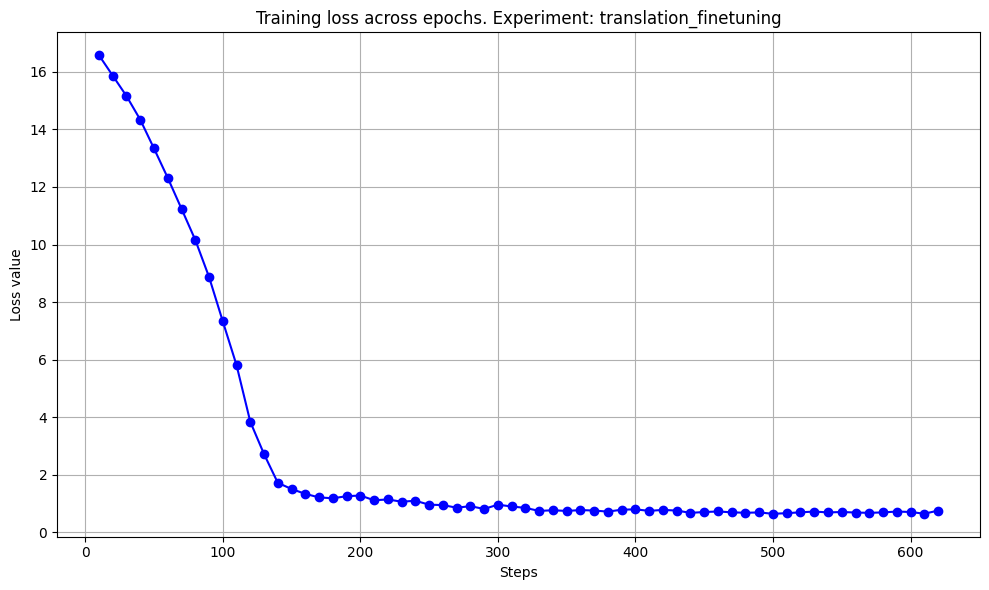

In [71]:
plot_loss_from_trainer_state('translation_finetuning', nb_chkpt=625)

## 5. Benchmark Fine-Tuned Models: Conclusions

In this last part, we see how to retrieve the trained adapters, plug them back into the pre-trained model to evaluate our fine-tuned models. The following code simply retrieves the latest checkpoint and plug the adapters. You see that, when using a trainer, it is very straightforward to evaluate the model as the `peft` library is designed to fetch adapters from trainer logs. And yes, we have to define pre-trained model again.

In [16]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    low_cpu_mem_usage = True,
    return_dict=True,
    torch_dtype = torch.float32,
    )

model.to(device)

adapter_model_name = './clm_finetuning/checkpoint-625'

clm_finetuned_model = PeftModel.from_pretrained(model, adapter_model_name)

Finally, we benchmark the fine-tuned model to see if it improved on the fine-tuning task compared to the pre-trained baseline:

In [26]:
metrics = evaluate_benchmark(clm_finetuned_model, tokenizer)
print(metrics)
display_radar_chart(metrics.values())


---------- Benchmarking Dialogue Summarization ----------


Map: 100%|██████████| 5/5 [00:00<00:00, 1245.93 examples/s]


Task summarization completed in 21.12s for 5 samples.

---------- Benchmarking Translation (English to French) ----------


Map: 100%|██████████| 5/5 [00:00<00:00, 1636.61 examples/s]


Task translation completed in 19.29s for 5 samples.

---------- Benchmarking Document Classification ----------


Map: 100%|██████████| 5/5 [00:00<00:00, 1905.46 examples/s]


Task classification completed in 17.53s for 5 samples.

---------- Benchmarking Causal Language Modeling ----------


Map: 100%|██████████| 5/5 [00:00<00:00, 1759.21 examples/s]


Task causal_language_modeling completed in 20.16s for 5 samples.


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]



---------- Benchmarking Emotion Load Detection ----------


Map: 100%|██████████| 5/5 [00:00<00:00, 1486.71 examples/s]


Task emotion_load_detection completed in 16.80s for 5 samples.
{'summarization': 0.13266677643747124, 'translation': 0.14020039295253683, 'classification': 0.26666666666666666, 'causal_language_modeling': 0.7622603391801606, 'emotion_load_detection': 0.8571428571428571}


In a regular fine-tuning setup, we would expect to obtain better results on the task(s) the model has been fine-tuned for. However, this is unlikely to be the case in this tutorial due to the limited amount of data and the small number of evaluated samples, which makes a fair assessment challenging. The primary aim of this section is to practice the various steps involved in the fine-tuning process rather than to achieve strong performance. Moreover, it is sometimes observed that the fine-tuned model is also better at a completely different task. Such outcomes are quite common and have contributed to research about [emergent abilities](https://arxiv.org/abs/2206.07682) of LLMs, though these abilities are [contested](https://arxiv.org/abs/2304.15004).  

Lastly, let's benchmark the second fine-tuned model, on translation. You see that the code logic is exactly the same:

In [104]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    low_cpu_mem_usage = True,
    return_dict=True,
    torch_dtype = torch.float32,
    )

model.to(device)

adapter_model_name = './translation_finetuning/checkpoint-500'

translation_finetuned_model = PeftModel.from_pretrained(model, adapter_model_name)

In [22]:
metrics = evaluate_benchmark(translation_finetuned_model, tokenizer)
print(metrics)
display_radar_chart(metrics.values())

NameError: name 'translation_finetuned_model' is not defined